## Prediciting Alternative Energy Stock Returns Using Linear Regression

### Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [4]:
YEAR = 252

### Load Data

In [5]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .drop(['Open', 'Close', 'Low', 'High'], axis=1))

In [6]:
data.index.names = ['Ticker', 'date']

Here we drop all the lag return columns

In [7]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

In [8]:
data = data.dropna()

### Create Model Data

We seperate our target columns from the dataset and store them in an independent variable. We add the rest to a seperate variable and drop the dollar volume columns. 

In [9]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank'], axis=1)

### Custom MultipleTimeSeriesCV

This class allows us to seperate the data into splits with defiend trianing and testing periods. 

In [10]:
class MultipleTimeSeriesCV:

    def __init__(self, n_splits = 8, train_period_length = 45, test_period_length = 14, shuffle = False, lookahead=None,):
        
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y = None, groups = None):
        
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        
        for i in range(self.n_splits):
            
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        
        for train_start, train_end, test_start, test_end in split_idx:
            
            train_idx = dates[(dates.date > days[train_start]) & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start]) & (dates.date <= days[test_end])].index
            
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Visualization methods

#### Prediction vs Actual Scatter Plot

In [11]:
def plot_preds_scatter(df, ticker=None):
    
    if ticker is not None:
        
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
        
    j = sns.jointplot(x = 'predicted', y = 'actuals',
                      robust = True, ci = None,
                      line_kws = {'lw': 1, 'color': 'k'},
                      scatter_kws = {'s': 1},
                      data = df,
                      stat_func = spearmanr,
                      kind = 'reg')
    
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

#### Daily Information Coefficent  Distribution

In [12]:
def plot_ic_distribution(df, ax=None):
    
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
        
    else:
        ax = sns.distplot(df.ic)
        
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    
    plt.tight_layout()

#### Rolling Daily Information Coefficent

In [13]:
def plot_rolling_ic(df):
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

### Linear Regression

#### Cross-Validation

This test used 63 trading days to train the model and then predicted 5-day returns for the following 10 days. As a result, we can use 20 10-day splits during the 2 years, starting in 2019.

In [14]:
train_period_length = 63
test_period_length = 10
n_splits = 20
lookahead = 5

cv = MultipleTimeSeriesCV(n_splits = n_splits,
                          test_period_length = test_period_length,
                          lookahead = lookahead,
                          train_period_length = train_period_length)

The cross-validation loop iterates over the train and test indices provided by TimeSeriesCV, selects features and outcomes, trains the model, and predicts the returns for the test features. 

In [15]:
%%time

target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()

for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    
    lr.fit(X = X_train, y = y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted = y_pred)
    preds_by_day = preds.groupby(level = 'date')
    
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted, x.actuals)[0] * 100)
                        .to_frame('ic'),
                        
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: user 1.21 s, sys: 15.6 ms, total: 1.22 s
Wall time: 682 ms


#### Store Results

In [16]:
lr_scores.to_hdf('data.h5', 'lr/scores')
lr_predictions.to_hdf('data.h5', 'lr/predictions')

In [17]:
lr_scores = pd.read_hdf('data.h5', 'lr/scores')
lr_predictions = pd.read_hdf('data.h5', 'lr/predictions')

#### Evaluate results

To evaluate the model's predictive performance, we can compute the information coefficient for each trading day, as well as for the entire period by pooling all forecasts.

The information coefficient shows how closely the financial forecasts match actual financial results. The IC can range from 1.0 to -1.0, with -1 indicating the forecasts bear no relation to the actual results, and 1 indicating that the forecasts perfectly matched actual results.

This test had an information coefficient of **-0.072** and a p-vlaue of **0.05**. This indicates that the model has negativce predicitve capability and nmo statistical significance. 

In [18]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): -7.237% (p-value: 0.0682%)


#### Prediction vs Actuals Scatter

The rank correlation of actual and predicted returns for the entire 2-year test period is negative at 0.074 and statistically insignificant:

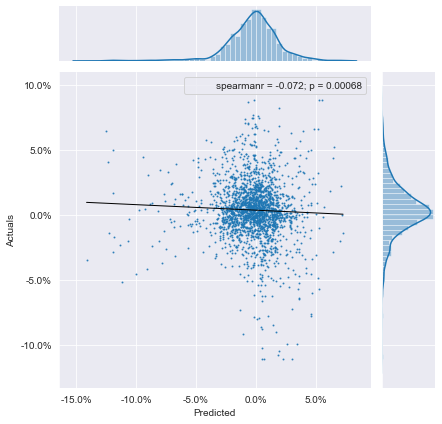

In [19]:
plot_preds_scatter(lr_predictions)

#### Daily IC Distribution

This shows the distribution of the rank correlation coefficients computed for each day and displays their mean and median, which are 4.81 and 4.55, respectively.

The seaborn jointplot estimates a robust regression that assigns lower weights to outliers and shows a small positive relationship, which is why the mean and median IC differ form the actual IC. This indicates that there are significant outliers in our dataset that are influencing the the overall information coefficent. 

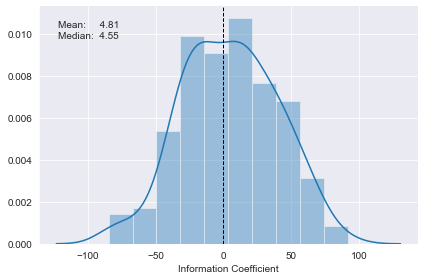

In [20]:
plot_ic_distribution(lr_scores)

#### Rolling Daily IC

This displays a 21-day rolling average for both the daily information coefficient and the RMSE, as well as their respective means for the validation period. This perspective highlights that the small positive IC for the entire period hides substantial variation that ranges from ~-20 to ~+25:

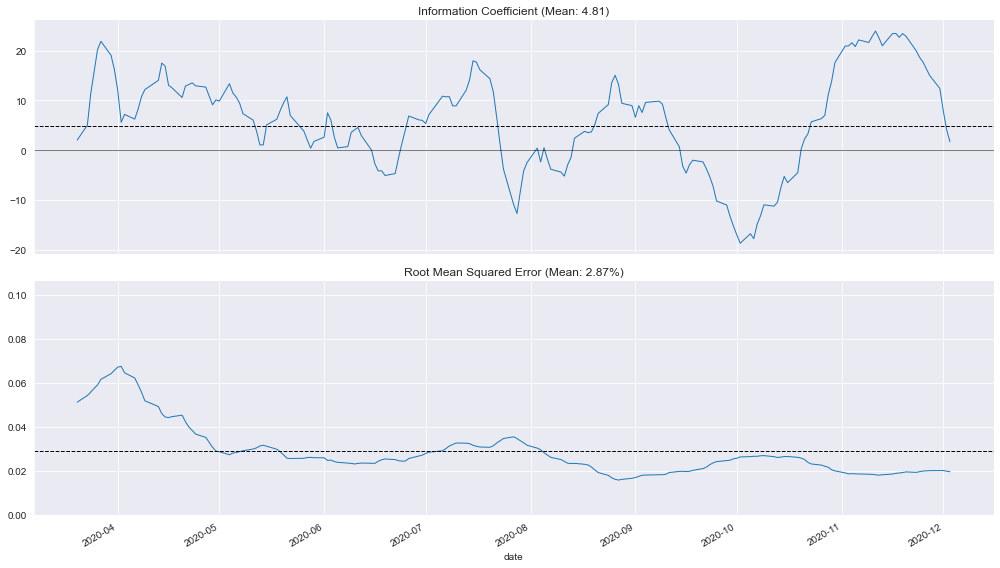

In [21]:
plot_rolling_ic(lr_scores)

### Ridge Regression

For ridge regression, we need to tune the regularization parameter with the keyword alpha, which corresponds to λ. We will try 18 values from $10^{-4}$ to $10^{4}$, where larger values imply stronger regularization:

#### Cross-Validation

In [22]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [23]:
train_period_length = 63
test_period_length = 10
n_splits = 20
lookahead = 5

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [24]:
target = f'target_{lookahead}d'
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

The scale sensitivity of the ridge penalty requires us to standardize the inputs using

In [25]:
%%time
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    
    print(alpha, end = ' ', flush=True)
    start = time()
    model = Ridge(alpha = alpha, fit_intercept = False, random_state = 42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X = X_train, y = y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted, x.actuals)[0] * 100).to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals))).to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha = alpha))
        ridge_predictions.append(preds.assign(alpha = alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
        
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: user 23.3 s, sys: 1.67 s, total: 24.9 s
Wall time: 13.7 s


#### Store Results

In [26]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('data.h5', 'ridge/predictions')

In [27]:
ridge_scores = pd.read_hdf('data.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf('data.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf('data.h5', 'ridge/predictions')

#### Evaluate results

The results show that we get the highest mean and median IC value for λ = 100.

In [28]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): -5.633% (p-value: 0.0000%)


In [29]:
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,200.0,4.811587,34.987122,-84.545455,-21.818182,4.545455,30.454545,91.818182
0.0005,200.0,4.811587,34.987122,-84.545455,-21.818182,4.545455,30.454545,91.818182
0.0010,200.0,4.811587,34.987122,-84.545455,-21.818182,4.545455,30.454545,91.818182
0.0050,200.0,4.811587,34.987122,-84.545455,-21.818182,4.545455,30.454545,91.818182
0.0100,200.0,4.811587,34.987122,-84.545455,-21.818182,4.545455,30.454545,91.818182
0.0500,200.0,4.811587,34.987122,-84.545455,-21.818182,4.545455,30.454545,91.818182
0.1000,200.0,4.811587,34.987122,-84.545455,-21.818182,4.545455,30.454545,91.818182
0.5000,200.0,4.861587,34.984271,-84.545455,-21.818182,4.545455,32.045455,91.818182
1.0000,200.0,4.847950,35.057855,-84.545455,-21.818182,5.000000,32.045455,91.818182


The charts below will help us visualize the performance of each λ value. 

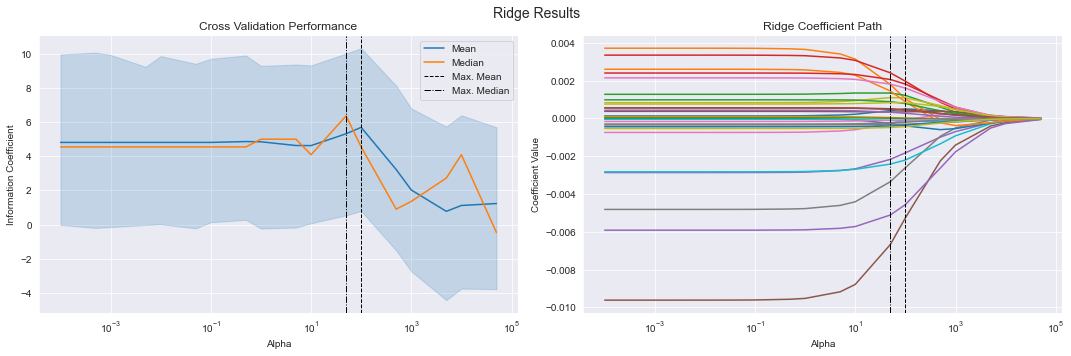

In [30]:
fig, axes = plt.subplots(ncols = 2, sharex = True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha',
                  y='ic',
                  data = ridge_scores,
                  estimator = np.mean,
                  label = 'Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')

axes[0].axvline(best_alpha_median, ls = '-.', c = 'k', lw = 1, label = 'Max. Median')

axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean, ls = '--', c = 'k', lw = 1, label = 'Max. Mean')
axes[1].axvline(best_alpha_median, ls = '-.', c = 'k', lw = 1, label = 'Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

The standardization of the coefficients allows us to draw conclusions about their relative importance by comparing their absolute magnitude.

We see that the Ridge Regression gives us slightly better performance than linear regression with a mean IC of 5.69%. However, this still indicates little overall predictive power. 

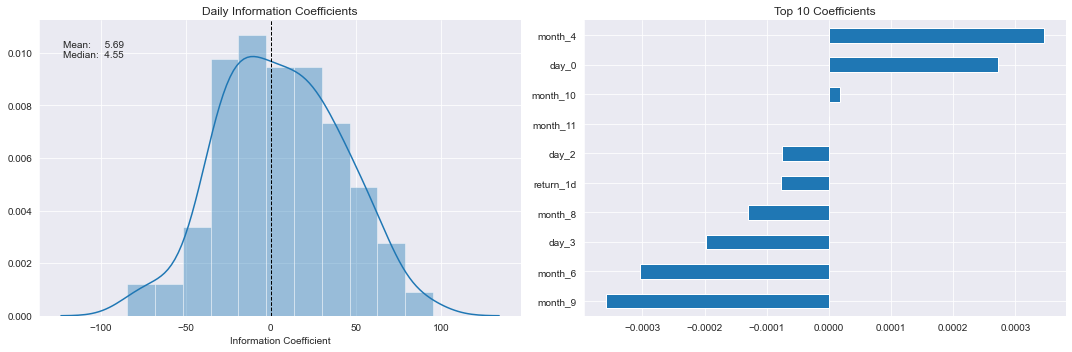

In [31]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()


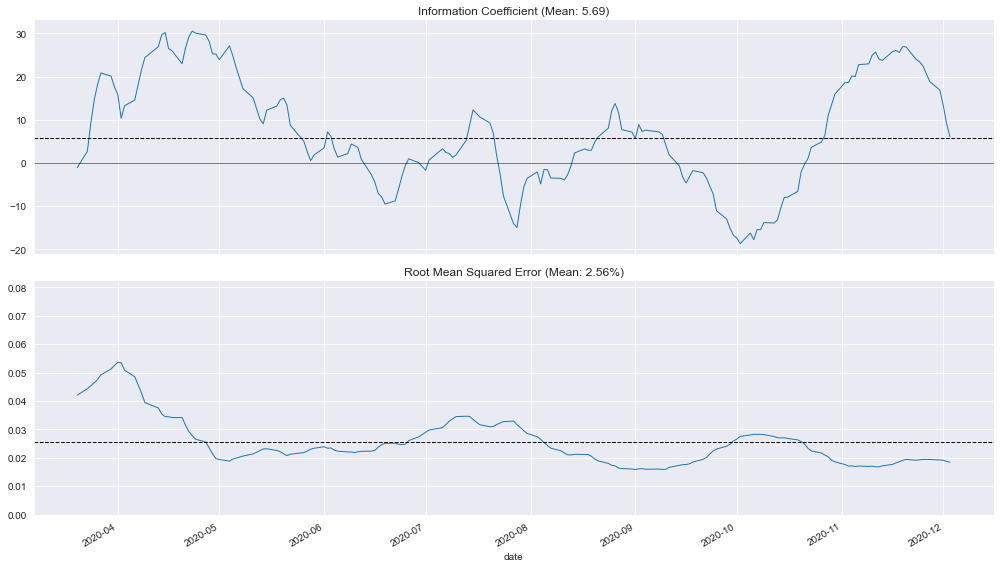

In [32]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha == best_alpha])

### Lasso CV

#### Cross Validation

The cross-validation code only differs with respect to the Pipeline setup

In [33]:
lasso_alphas = np.logspace(-10, -3, 8)

In [34]:
train_period_length = 63
test_period_length = 10
n_splits = 20
lookahead = 5

In [35]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

#### Cross-Validation with Lasso regression

In [36]:
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [37]:
%%time

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    
    model = Lasso(alpha=alpha, 
                  fit_intercept = False, 
                  random_state = 42, 
                  tol = 1e-3, 
                  max_iter = 1000, 
                  warm_start = True, 
                  selection = 'random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    
    coeffs = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X = X_train, y = y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')],
                           axis=1)

        lasso_scores.append(scores.assign(alpha = alpha))
        lasso_predictions.append(preds.assign(alpha = alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis = 0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 CPU times: user 13.2 s, sys: 97.4 ms, total: 13.3 s
Wall time: 7.12 s


#### Results

In [38]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf('data.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf('data.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf('data.h5', 'lasso/predictions')

Visualization of the results

In [39]:
lasso_predictions.head()

actuals  predicted         alpha
Ticker date                                         
BE     2020-11-19  0.064396   0.007359  1.000000e-10
       2020-11-20  0.056028   0.015226  1.000000e-10
       2020-11-23  0.022016   0.001024  1.000000e-10
       2020-11-24 -0.006150   0.000778  1.000000e-10
       2020-11-25 -0.024959  -0.003002  1.000000e-10

#### Evaluation

In [40]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 14.606% (p-value: 0.0000%)


In [41]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,4.811587,4.545455
1.000000e-09,4.811587,4.545455
1.000000e-08,4.811587,4.545455
1.000000e-07,4.811587,4.545455
1.000000e-06,4.807041,4.545455
1.000000e-05,4.684314,5.000000
1.000000e-04,5.216173,6.363636
1.000000e-03,5.654670,6.363636


### Lasso Coefficient Path

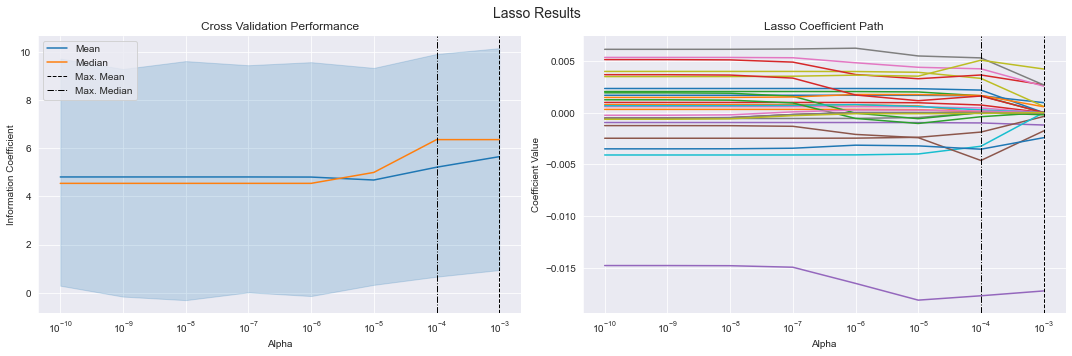

In [42]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

### Lasso IC Distribution and Top 10 Features

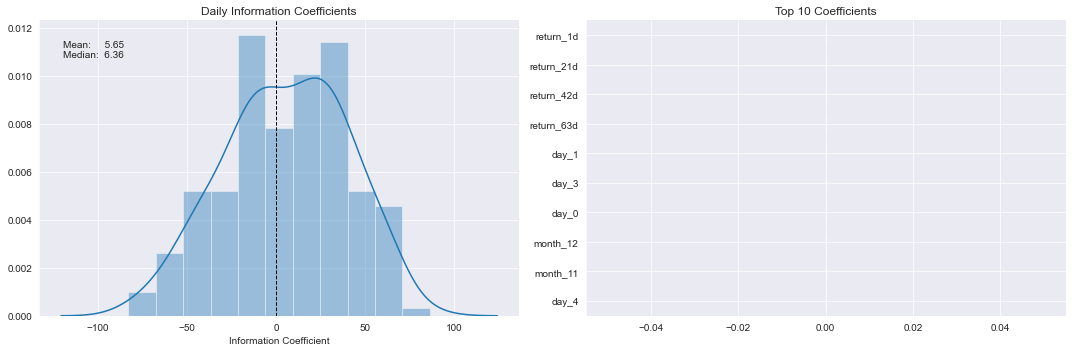

In [43]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

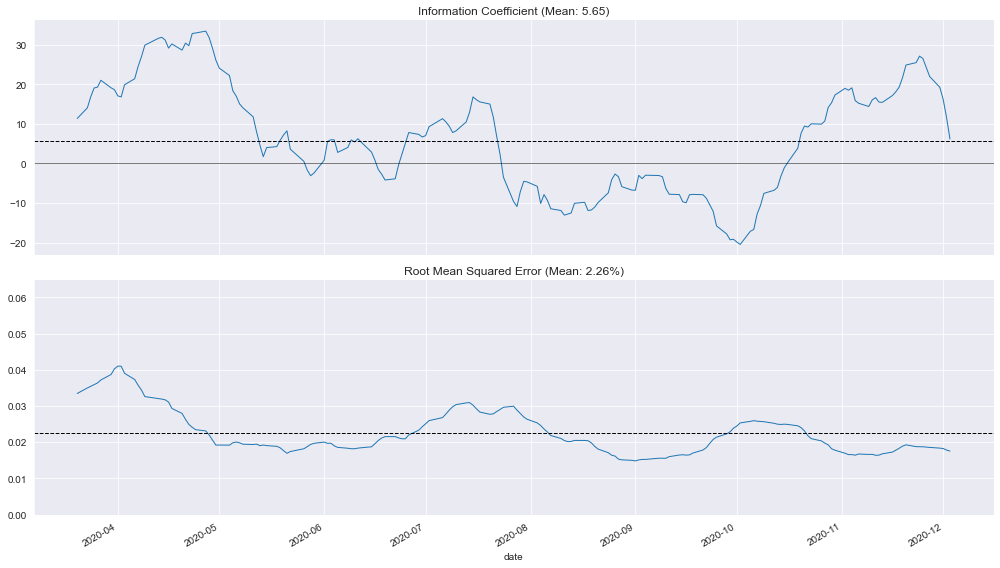

In [44]:
plot_rolling_ic(lasso_scores[lasso_scores.alpha==best_alpha])

### Compare results

Here we compare the reuslts of each model. We see that the Lasso regression model outperforms both linear and ridge. However, it seems the variance in the movement of the stocks is significantly hindering the predictive merit of any of the models. 

With an average IC of 8%, even our best model performs only slightly better than a model that would randomly guess the direction of any gievn stock (0%). Clealry, the data has far too much variance for linear regression models to have any kind of predictive signifigance. 

In [45]:
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [46]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [47]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)

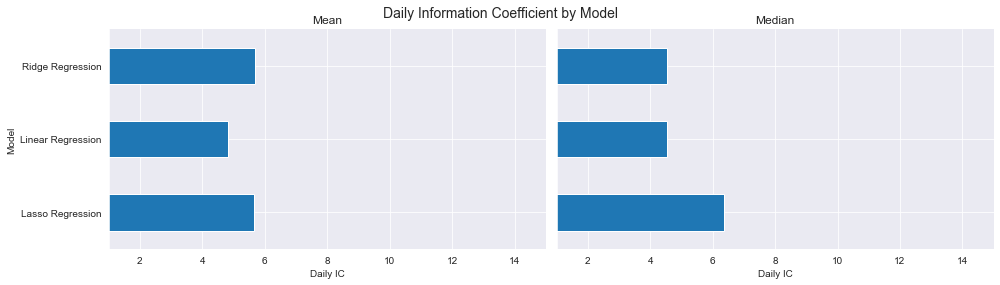

In [48]:
scores = df.groupby('Model').ic.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(1, 15), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(1, 15), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)